In [1]:
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from transformers import  BertTokenizer,DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import  AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 

from DataFun import *
# %reload_ext autoreload
# %autoreload 1
# %aimport LSTM_pytorch

from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch as LSTM_pytorch


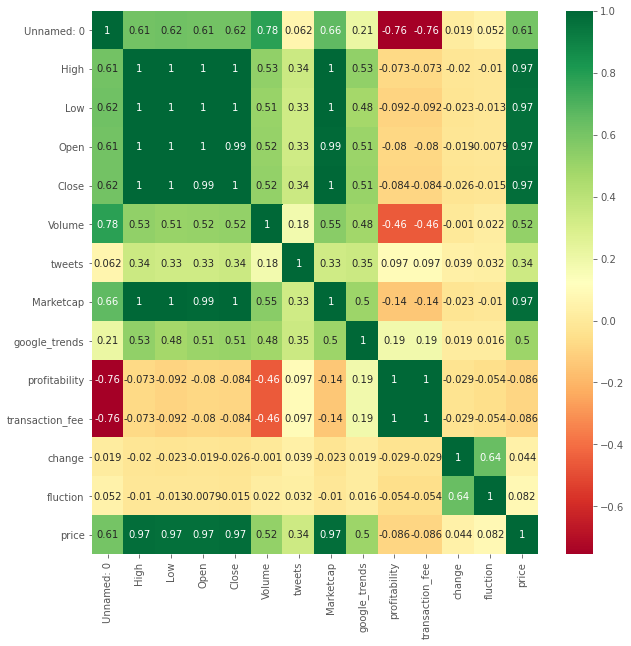

In [2]:
filepath = f"./data/ETH_Data.csv"
keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends']
targets = ["price"]
ETH_df = pd.read_csv(filepath, infer_datetime_format=True,
                         parse_dates=True)
ETH_df=ETH_df.fillna(0)


corrmat = ETH_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
ax=sns.heatmap(ETH_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

# top: "change","transaction_fee","profitablity","volume","tweets","google_trends","close"

## With BASELINE LM

In [3]:
hidden_dim = 1
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 50

keys = ['Close', 'Volume', 'tweets', 'google_trends',
        'transaction_fee', 'price','Negative','Positive']

In [4]:
def train_record(input_dim, seq_dim, train_loader,val_loader,hidden_dim,
                 layer_dim,output_dim,num_epochs):
    training_record=[]
    for i in range(10):
        model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                         seq_dim=seq_dim,
                                                         train_loader=train_loader,
                                                         val_loader=val_loader,
                                                         hidden_dim=hidden_dim,
                                                         layer_dim=layer_dim,
                                                         output_dim=output_dim,
                                                         num_epochs = num_epochs)
        training_record.append([model,train_loss,val_loss])
    return training_record

In [5]:


file_sentiment=f'./data/LM_dic_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('Date')
df=df.set_index('Date')
LM_df=pd.concat([df, sentiment[['Negative','Positive']]], axis=1, join='inner')

targets = ["price"]



In [ ]:
LM_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, LM_scaler) = LSTM_pytorch.dataloading(
                                                    df= LM_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+LM",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
LM_prediction_record=prediction_record
total_record =LM_prediction_record


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=LM_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
total_model_record=None
total_model_record=pd.DataFrame(columns=["model","score",
                                         "sentiment_method","MSE","RMSE","R2"])
score="MSE"
total_model_record=total_model_record.append({"model":"LM_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+LM","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:
from statsmodels.tsa.api import VAR
from VAR import *
# ETH_df = pd.read_csv('./data/ETH_Data.csv', encoding='latin-1').iloc[:, 1:]
# ETH_df = ETH_df.set_index(['Date'])



tweets_mean = LM_df["tweets"].mean()
LM_df["tweets"] = LM_df["tweets"].fillna(tweets_mean)
keys = ['Close', 'Volume', 'tweets', 'google_trends',
        'transaction_fee', 'price', 'Negative', 'Positive']
targets = ["price"]
LM_df=LM_df[keys][:-1]

#ETH_df = df_differenced[keys]#'change'
split = int(0.7 * len(LM_df))
train_dataset = LM_df[0: split - 1]
test_dataset = LM_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(4)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=MSE(prediction,actual)
VAR_1_R2=R2(actual,prediction)
VAR_1_rmse=rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_LM",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:
import DataFun
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(LM_df)
LM_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,LM_df)
prediction=result["price"]
actual=LM_df["price"]
VAR_1_mse=MSE(prediction,actual)
VAR_1_R2=R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_LM","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### BERT_uncased_base

In [ ]:
keys=['Close', 'Volume', 'tweets', 'google_trends', 'transaction_fee',
 'price', 'negative', 'positive']
file_sentiment=f'./data/bert-base-uncased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
BERT_u_b_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]



In [ ]:
BERT_u_b_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, BERT_u_b_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= BERT_u_b_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+BERT_u_b",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
BERT_u_b_df_prediction_record=prediction_record
total_record =total_record.append(BERT_u_b_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=BERT_u_b_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = BERT_u_b_df["tweets"].mean()
BERT_u_b_df["tweets"] = BERT_u_b_df["tweets"].fillna(tweets_mean)
targets = ["price"]
BERT_u_b_df=BERT_u_b_df[keys][:-1]
split = int(0.7 * len(BERT_u_b_df))
train_dataset = BERT_u_b_df[0: split - 1]
test_dataset = BERT_u_b_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(3)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_BERT_u_b",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(BERT_u_b_df)
BERT_u_b_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,BERT_u_b_df)
prediction=result["price"]
actual=BERT_u_b_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_BERT_u_b_df","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### BERT_cased_base

In [ ]:
keys=['Close', 'Volume', 'tweets', 'google_trends', 'transaction_fee',
 'price', 'negative', 'positive']
file_sentiment=f'./data/bert-base-cased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
BERT_c_b_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]



In [ ]:
BERT_c_b_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, BERT_c_b_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= BERT_c_b_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+BERT_c_b",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
BERT_c_b_df_prediction_record=prediction_record
total_record =total_record.append(BERT_c_b_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=BERT_c_b_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_c_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"BERT_c_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = BERT_c_b_df["tweets"].mean()
BERT_c_b_df["tweets"] = BERT_c_b_df["tweets"].fillna(tweets_mean)
targets = ["price"]
BERT_c_b_df=BERT_c_b_df[keys][:-1]
split = int(0.7 * len(BERT_c_b_df))
train_dataset = BERT_c_b_df[0: split - 1]
test_dataset = BERT_c_b_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(7)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_BERT_c_b",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(BERT_c_b_df)
BERT_c_b_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,BERT_c_b_df)
prediction=result["price"]
actual=BERT_c_b_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_BERT_c_b_df","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### BERT_uncased_large


In [ ]:
file_sentiment=f'./data/bert-large-uncased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
BERT_u_l_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]

In [ ]:
BERT_u_l_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, BERT_u_l_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= BERT_u_l_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+BERT_u_l",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
BERT_u_l_df_prediction_record=prediction_record
total_record =total_record.append(BERT_u_l_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=BERT_u_l_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = BERT_u_l_df["tweets"].mean()
BERT_u_l_df["tweets"] = BERT_u_l_df["tweets"].fillna(tweets_mean)
targets = ["price"]
BERT_u_l_df=BERT_u_l_df[keys][:-1]
split = int(0.7 * len(BERT_u_l_df))
train_dataset = BERT_u_l_df[0: split - 1]
test_dataset = BERT_u_l_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(7)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_BERT_u_l",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(BERT_u_l_df)
BERT_u_l_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,BERT_u_l_df)
prediction=result["price"]
actual=BERT_u_l_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_BERT_u_l_df","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### BERT_cased_large


In [ ]:
keys=['Close', 'Volume', 'tweets', 'google_trends', 'transaction_fee',
 'price', 'negative', 'positive']
file_sentiment=f'./data/bert-large-cased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
BERT_c_l_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]



In [ ]:
BERT_c_l_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, BERT_c_l_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= BERT_c_l_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+BERT_c_l",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
BERT_c_l_df_prediction_record=prediction_record
total_record =total_record.append(BERT_c_l_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=BERT_c_l_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_c_l_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"BERT_c_l_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = BERT_c_l_df["tweets"].mean()
BERT_c_l_df["tweets"] = BERT_c_l_df["tweets"].fillna(tweets_mean)
targets = ["price"]
BERT_c_l_df=BERT_c_l_df[keys][:-1]
split = int(0.7 * len(BERT_c_l_df))
train_dataset = BERT_c_l_df[0: split - 1]
test_dataset = BERT_c_l_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(3)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_BERT_c_l",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(BERT_c_l_df)
BERT_c_l_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,BERT_c_l_df)
prediction=result["price"]
actual=BERT_c_l_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_BERT_c_l","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### RoBERTa

In [ ]:
file_sentiment=f'./data/roberta_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
RoBERTa_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]

In [ ]:
RoBERTa_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, RoBERTa_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+RoBERTa",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
RoBERTa_df_prediction_record=prediction_record
total_record =total_record.append(RoBERTa_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=RoBERTa_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"RoBERTa_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = RoBERTa_df["tweets"].mean()
RoBERTa_df["tweets"] = RoBERTa_df["tweets"].fillna(tweets_mean)
targets = ["price"]
RoBERTa_df=RoBERTa_df[keys][:-1]
split = int(0.7 * len(RoBERTa_df))
train_dataset = RoBERTa_df[0: split - 1]
test_dataset = RoBERTa_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(7)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_RoBERTa",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(RoBERTa_df)
RoBERTa_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,RoBERTa_df)
prediction=result["price"]
actual=RoBERTa_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_RoBERTa","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### DistilBERT


In [ ]:
file_sentiment=f'./data/distilbert_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
DistilBERT_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]

In [ ]:
DistilBERT_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, DistilBERT_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= DistilBERT_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+Distil",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
DistilBERT_df_prediction_record=prediction_record
total_record =total_record.append(DistilBERT_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=DistilBERT_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"BERT_u_b_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = DistilBERT_df["tweets"].mean()
DistilBERT_df["tweets"] = DistilBERT_df["tweets"].fillna(tweets_mean)
targets = DistilBERT_df["price"]
DistilBERT_df=DistilBERT_df[keys][:-1]
split = int(0.7 * len(DistilBERT_df))
train_dataset = DistilBERT_df[0: split - 1]
test_dataset = DistilBERT_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(4)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_DistilBERT_df",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(DistilBERT_df)
DistilBERT_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,DistilBERT_df)
prediction=result["price"]
actual=DistilBERT_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_DistilBERT_df","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


### FinBERT

In [ ]:
file_sentiment=f'./data/FinBert_pre_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
FinBERT_df=pd.concat([df, sentiment[['negative','neutral','positive','sentiment']]], axis=1, join='inner')

targets = ["price"]

FinBERT_df_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, FinBERT_df_scaler) = LSTM_pytorch.dataloading(
                                                    df= FinBERT_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
training_record=train_record(input_dim=input_dim,
                             seq_dim=seq_dim,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             hidden_dim=hidden_dim,
                             layer_dim=layer_dim,
                             output_dim=output_dim,
                             num_epochs = num_epochs)

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+FinBERT",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)
FinBERT_df_df_prediction_record=prediction_record
total_record =total_record.append(FinBERT_df_df_prediction_record,ignore_index=True)


In [ ]:
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=FinBERT_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)

data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="MSE"
total_model_record=total_model_record.append({"model":"FinBERT_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)
score="R2"
total_model_record=total_model_record.append({"model":"FinBERT_LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:

tweets_mean = FinBERT_df["tweets"].mean()
FinBERT_df["tweets"] = FinBERT_df["tweets"].fillna(tweets_mean)
targets = FinBERT_df["price"]
FinBERT_df=FinBERT_df[keys][:-1]
split = int(0.7 * len(FinBERT_df))
train_dataset = FinBERT_df[0: split - 1]
test_dataset = FinBERT_df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())

In [ ]:
VAR_model_fitted1=VAR_model.fit(3)

In [ ]:
prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

result=VAR_forecast(VAR_model_fitted1,test_dataset)
prediction=result["price"]
actual=test_dataset["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
prediction_record=prediction_record.append({"model_name":"VAR_FinBERT",
                                                "model":index,
                                                "MSE":VAR_1_mse,
                                                "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

total_record = total_record.append(prediction_record,ignore_index=True)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(FinBERT_df)
FinBERT_df = pd.DataFrame(df_scaled_train,columns=keys)
result=VAR_forecast(VAR_model_fitted1,FinBERT_df)
prediction=result["price"]
actual=FinBERT_df["price"]
VAR_1_mse=DataFun.MSE(prediction,actual)
VAR_1_R2=DataFun.R2(actual,prediction)
VAR_1_rmse=DataFun.rmse(prediction,actual)
print('MSE = {}'.format(VAR_1_mse))
print('RMSE = {}'.format(VAR_1_rmse))
print('R-Squared Score = {}'.format(VAR_1_R2))

plot_data(actual,prediction)
score="MSE"
total_model_record=total_model_record.append({"model":"VAR_FinBERT","score":score,"sentiment_method": "no sentiment",
                      "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)


In [ ]:
total_record["RMSE"]=np.sqrt(total_record["MSE"])
total_record.groupby("model_name").max("MSE")

In [ ]:
total_model_record["RMSE"]=np.sqrt(total_model_record["MSE"])
total_model_record

In [ ]:
total_model_record.loc[total_model_record["score"]=="MSE"].sort_values("MSE")